# คำนวณค่าสถิติความสัมพันธ์ฝนสสน.กับฝนเรดาร์รายวันทุกเหตุการณ์ในแต่ละcappi พลอตกราฟ
* อ่านและคลีนข้อมูล กรองข้อมูล dBZ10-55
* คำนวณค่า ZRs ของแต่ะล cappi
* คำนวณ matrics สถิติระหว่างความสัมพันธ์ของฝนสองแหล่ง
* พลอตกราฟ
* หมายเหตุ: ฝนรายชั่วโมง ได้มาจากการหาค่า mean dBZ รายชั่วโมง ณ กริดนั้น ๆ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## read cleansing

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events_mean_dBZ/df_org_dbz_rain_test120km.csv')
#df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test200km.csv')
df.drop(df[df['cappi4km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0
...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0


### เปลี่ยนชื่อคอลัมน์

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0
...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0


## แปลง dBZ เป็น rain rate ด้วย ZRs

In [4]:
def dBZ_to_rainrate_by_zr(dBZ, a=200, b=1.6):
    z = 10**(dBZ/10)
    r = (z/a)**(1/b)
    return r

### Marshall/Palmer ZR

In [5]:
# Specify the columns for dBZ and rain rate
dBZ_columns = ['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
rain_rate_columns = ['rr_MP_c1', 'rr_MP_c2', 'rr_MP_c3', 'rr_MP_c4']
a=200
b=1.6

# Apply the dBZ_to_rainrate_by_zr function to the specified columns
for dBZ_col, rain_rate_col in zip(dBZ_columns, rain_rate_columns):
    df[rain_rate_col] = dBZ_to_rainrate_by_zr(df[dBZ_col],a,b)

df.head()

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0,1.273687,1.186179,0.656222,0.711362
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0,1.396314,1.077049,1.065285,1.188544
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820252,1.820251
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0,0.970859,1.195389,1.691887,2.039476
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0,0.711009,0.687794,0.622425,0.578014


### Rosenfeld Zr

In [6]:
# Specify the columns for dBZ and rain rate
dBZ_columns = ['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
rain_rate_columns = ['rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4']
a=250. 
b=1.2

# Apply the dBZ_to_rainrate_by_zr function to the specified columns
for dBZ_col, rain_rate_col in zip(dBZ_columns, rain_rate_columns):
    df[rain_rate_col] = dBZ_to_rainrate_by_zr(df[dBZ_col],a,b)

df.head()

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0,1.273687,1.186179,0.656222,0.711362,1.146371,1.042578,0.473488,0.527265
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0,1.396314,1.077049,1.065285,1.188544,1.295843,0.916690,0.903363,1.045351
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820252,1.820251,1.845370,1.845370,1.845371,1.845370
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0,0.970859,1.195389,1.691887,2.039476,0.798209,1.053385,1.673928,2.147500
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0,0.711009,0.687794,0.622425,0.578014,0.526916,0.504103,0.441256,0.399784


### Summer Deep Convective ZR

In [7]:
# Specify the columns for dBZ and rain rate
dBZ_columns = ['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
rain_rate_columns = ['rr_SC_c1', 'rr_SC_c2', 'rr_SC_c3', 'rr_SC_c4']

a=300. 
b=1.4

# Apply the dBZ_to_rainrate_by_zr function to the specified columns
for dBZ_col, rain_rate_col in zip(dBZ_columns, rain_rate_columns):
    df[rain_rate_col] = dBZ_to_rainrate_by_zr(df[dBZ_col],a,b)

df.head()

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0,1.273687,1.186179,0.656222,0.711362,1.146371,1.042578,0.473488,0.527265,0.986943,0.909837,0.462525,0.507202
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0,1.396314,1.077049,1.065285,1.188544,1.295843,0.916690,0.903363,1.045351,1.096265,0.814819,0.804655,0.911911
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820252,1.820251,1.845370,1.845370,1.845371,1.845370,1.484272,1.484272,1.484272,1.484272
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0,0.970859,1.195389,1.691887,2.039476,0.798209,1.053385,1.673928,2.147500,0.723672,0.917915,1.365263,1.690270
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0,0.711009,0.687794,0.622425,0.578014,0.526916,0.504103,0.441256,0.399784,0.506914,0.488044,0.435403,0.400083


#### ดรอปคอมลัมน์ cappi ทิ้ง

In [8]:
#### ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01-00:00,CMSG,0.0,1.273687,1.186179,0.656222,0.711362,1.146371,1.042578,0.473488,0.527265,0.986943,0.909837,0.462525,0.507202
1,2018-06-01-00:00,KGTP,0.0,1.396314,1.077049,1.065285,1.188544,1.295843,0.916690,0.903363,1.045351,1.096265,0.814819,0.804655,0.911911
2,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820252,1.820251,1.845370,1.845370,1.845371,1.845370,1.484272,1.484272,1.484272,1.484272
3,2018-06-01-00:00,NAN011,0.0,0.970859,1.195389,1.691887,2.039476,0.798209,1.053385,1.673928,2.147500,0.723672,0.917915,1.365263,1.690270
4,2018-06-01-00:00,SLBC,0.0,0.711009,0.687794,0.622425,0.578014,0.526916,0.504103,0.441256,0.399784,0.506914,0.488044,0.435403,0.400083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8656,2018-09-21-16:00,TPKO,0.0,0.403353,0.330749,0.249307,0.205053,0.247451,0.189921,0.130283,0.100399,0.265201,0.211386,0.153029,0.122400
8657,2018-09-21-17:00,CNDN,0.2,1.257301,1.274637,1.205704,1.054208,1.126750,1.147512,1.065522,0.890861,0.972446,0.987785,0.926973,0.795101
8658,2018-09-21-17:00,NAN005,0.0,4.020371,3.615000,3.460884,2.943195,5.307987,4.606659,4.346681,3.502141,3.671220,3.251312,3.093387,2.570477
8659,2018-09-21-17:00,NGBA,0.0,1.758216,1.745019,0.519070,1.044052,1.761994,1.744383,0.346372,0.879436,1.426602,1.414372,0.353805,0.786352


#### รวมฝนรายชั่วโมงเป็นรายวัน ด้วยการสร้างคอลัมน์ date_only เพื่อใช้ร่วมกับคอลัมน์ code

In [9]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

aggregated_data.head()

,date_only,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01,BPPS,0.2,1.863638,1.637148,1.805962,2.206973,1.577677,1.305313,1.509974,1.942876,1.403455,1.202593,1.352917,1.691518
1,2018-06-01,CMSG,4.8,15.745538,14.514371,14.206068,15.196123,19.252761,16.897112,16.697594,18.567472,13.831574,12.498505,12.274215,13.338449
2,2018-06-01,CNDN,0.0,5.869510,6.950422,4.116697,3.348057,8.791119,11.013447,5.478229,4.158776,5.657475,6.863080,3.771917,2.978406
3,2018-06-01,DIV003,0.0,3.071936,2.678807,2.777564,2.623048,3.103048,2.563887,2.607401,2.405885,2.494264,2.126117,2.189727,2.047935
4,2018-06-01,DIV005,0.0,0.712271,0.714967,0.911959,1.092430,0.528164,0.530831,0.734303,0.934186,0.507943,0.510141,0.673718,0.828131


#### conditional rain
เป็นหนึ่งในกระบวนการ QC การจับคู่ของฝนเรดาร์กับฝนสถานี อ่านรายละเอียด
http://www.iapjournals.ac.cn/fileDQKXJZ/journal/article/dqkxjz/2012/3/PDF/110139.pdf

In [10]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_SC_c1']>0]
df_.reset_index(drop=True, inplace=True)
df_.describe()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
count,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,6.129448,11.385044,11.207611,11.210664,11.067666,17.857101,17.011808,16.547400,15.984553,10.878929,10.574570,10.470740,10.245955
std,9.208948,13.389724,12.443678,12.033307,12.245483,34.371919,31.698243,29.903933,31.278439,15.940008,14.714650,14.041062,14.404458
min,0.200000,0.177591,0.169650,0.187247,0.166486,0.082884,0.077979,0.088946,0.076046,0.103852,0.098562,0.110330,0.096464
25%,0.400000,3.753066,3.757482,3.705922,3.806149,3.154635,3.251440,3.358838,3.415329,2.880526,2.884169,2.918392,3.009777
50%,2.000000,6.954112,7.172705,7.571260,7.541627,6.741200,6.968069,7.652011,7.418207,5.580723,5.713994,6.083977,6.090101
75%,7.800000,13.060170,13.937973,14.265413,13.577596,15.947656,16.789942,17.571704,16.779570,11.374513,12.199663,12.445468,11.777351
max,77.800000,108.148532,113.156216,118.655361,169.342932,365.000616,361.679610,345.036764,553.876923,144.092948,150.332607,151.027503,226.052636


In [11]:
df_.corr()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
rain_truth,1.000000,0.549744,0.559747,0.588649,0.522502,0.481666,0.474909,0.507287,0.421055,0.523679,0.527728,0.560395,0.485225
rr_MP_c1,0.549744,1.000000,0.949216,0.855118,0.716186,0.958514,0.896429,0.794190,0.616498,0.990004,0.935605,0.838360,0.681719
rr_MP_c2,0.559747,0.949216,1.000000,0.924800,0.777167,0.897939,0.950453,0.867348,0.674948,0.933236,0.988089,0.910362,0.742424
rr_MP_c3,0.588649,0.855118,0.924800,1.000000,0.923067,0.783266,0.852025,0.946941,0.836365,0.827372,0.899792,0.987381,0.896832
rr_MP_c4,0.522502,0.716186,0.777167,0.923067,1.000000,0.632505,0.685504,0.866846,0.941376,0.680252,0.740073,0.905796,0.986077
rr_RF_c1,0.481666,0.958514,0.897939,0.783266,0.632505,1.000000,0.931125,0.800797,0.601413,0.988824,0.926080,0.804605,0.632081
rr_RF_c2,0.474909,0.896429,0.950453,0.852025,0.685504,0.931125,1.000000,0.888066,0.664441,0.922333,0.986615,0.882805,0.690822
rr_RF_c3,0.507287,0.794190,0.867348,0.946941,0.866846,0.800797,0.888066,1.000000,0.881573,0.805128,0.888106,0.985537,0.890429
rr_RF_c4,0.421055,0.616498,0.674948,0.836365,0.941376,0.601413,0.664441,0.881573,1.000000,0.614658,0.677769,0.867712,0.984004
rr_SC_c1,0.523679,0.990004,0.933236,0.827372,0.680252,0.988824,0.922333,0.805128,0.614658,1.000000,0.940394,0.829779,0.663017


## EDA

### Correlation matrix

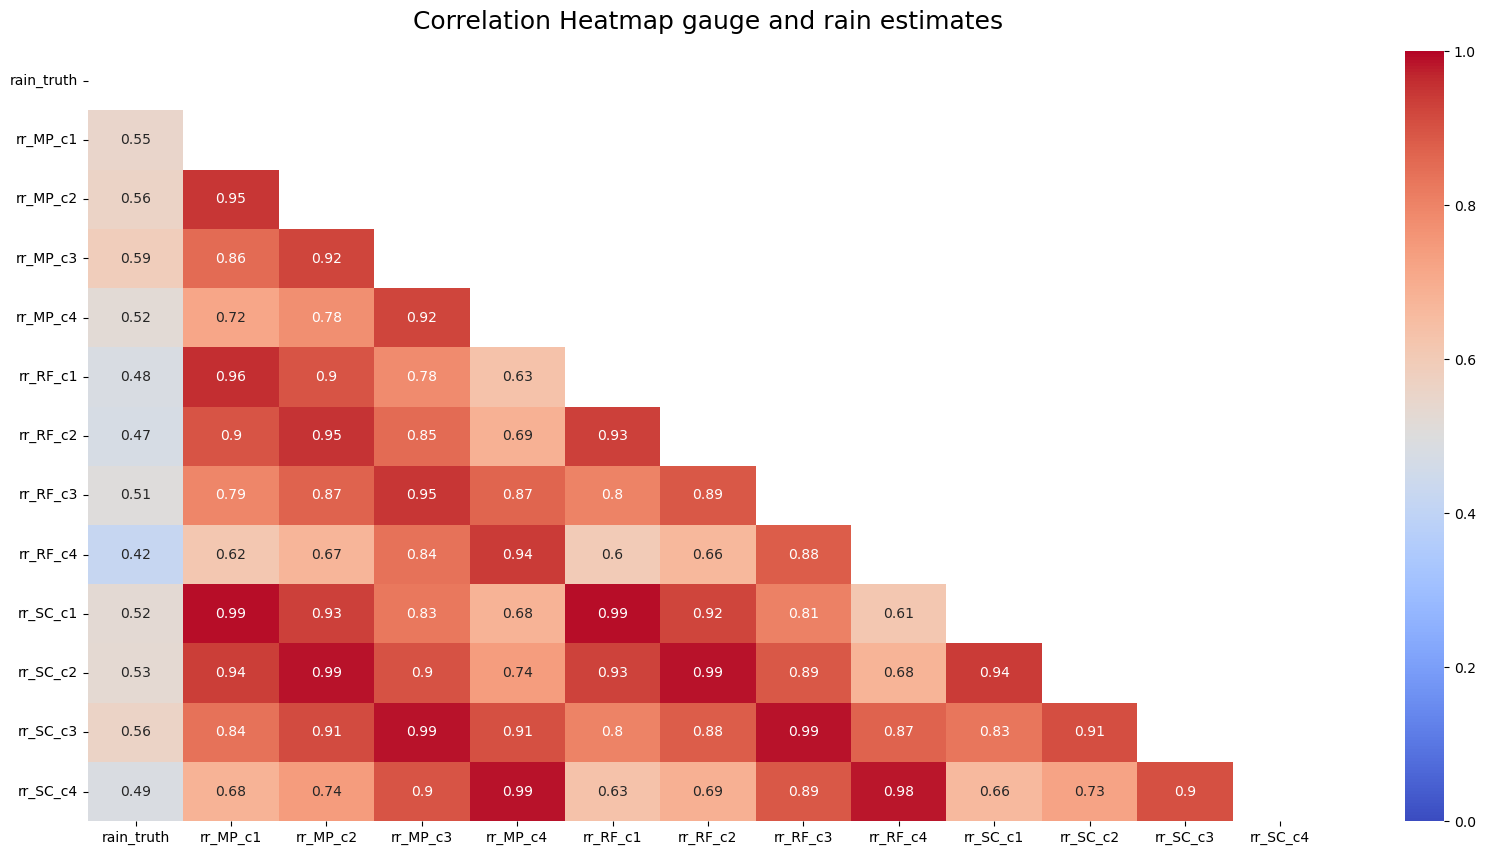

In [12]:
plt.figure(figsize=(20, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_.corr(), dtype=bool))
heatmap = sns.heatmap(df_.corr(), mask=mask, vmin=0, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap gauge and rain estimates', fontdict={'fontsize':18}, pad=16);

### Scatter plot & สถิติจากฝนสองแหล่ง

In [13]:
def density_plot(rain_truth, rain_radar,cappi_height):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)

    
    max_ = 50
    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_truth [mm/hr]')
    plt.ylabel('rain_radar [mm/hr]')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Calculate metrics
    bias = rain_radar.mean()/rain_truth.mean()
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Plot the regression line
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain '+ cappi_height + '[mm/day]')
    plt.legend()

    # Display the plot
    plt.show()
    
    return bias,rmse,mse,mae,r2,r_value
    


RMSE: 12.490166049824515
MSE: 156.00424795218893
MAE: 7.701075204774146
R-squared: 0.12894553980379375
Correlation coefficient (r): 0.5497443065852334
P-value: 5.4088632056889256e-77


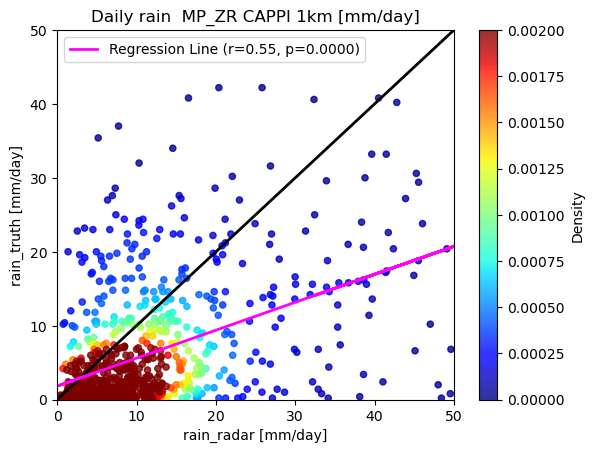

RMSE: 11.706210164941737
MSE: 137.03535642578524
MAE: 7.333256262341555
R-squared: 0.11409473101551137
Correlation coefficient (r): 0.5597468120993877
P-value: 2.4363430359044583e-80


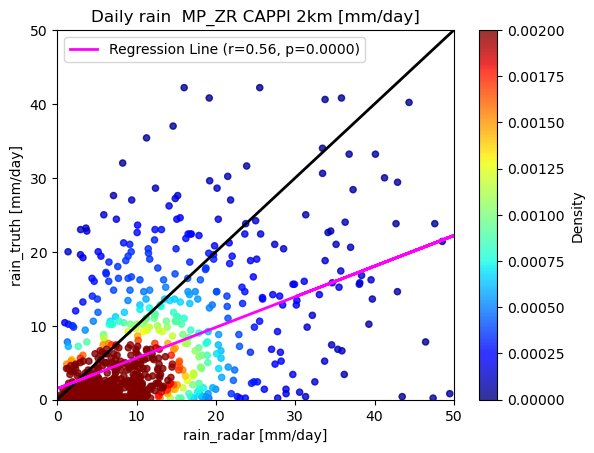

RMSE: 11.174053715091382
MSE: 124.85947642774754
MAE: 7.250215880139728
R-squared: 0.13681545772995474
Correlation coefficient (r): 0.58864941805631
P-value: 1.1165570462883882e-90


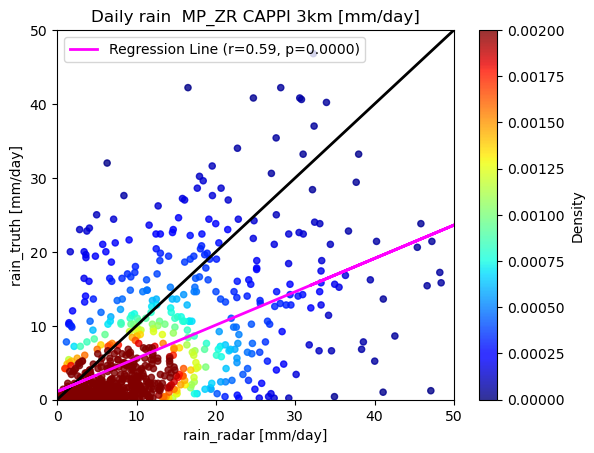

RMSE: 11.881825480560224
MSE: 141.1777767504902
MAE: 7.451583631133239
R-squared: 0.057531910366908856
Correlation coefficient (r): 0.5225024937079933
P-value: 1.9717290759195563e-68


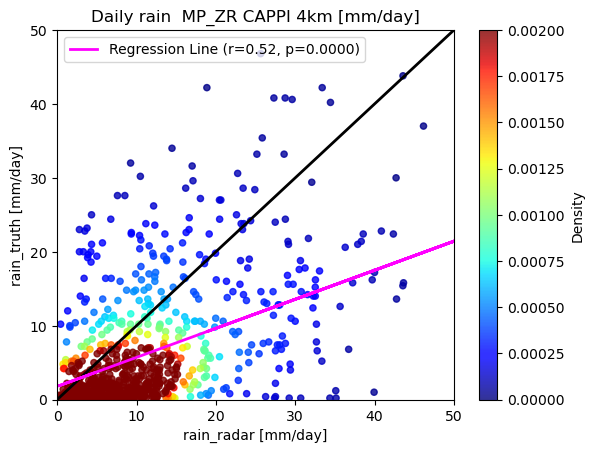

,0,1,2,3,4,5
0,1.857434,12.490166,156.004248,7.701075,0.128946,0.549744
1,1.828486,11.706210,137.035356,7.333256,0.114095,0.559747
2,1.828984,11.174054,124.859476,7.250216,0.136815,0.588649
3,1.805655,11.881825,141.177777,7.451584,0.057532,0.522502


In [14]:
stat_mp=[]
bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_MP_c1'],' MP_ZR CAPPI 1km ')
stat_mp.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_MP_c2'],' MP_ZR CAPPI 2km ')
stat_mp.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_MP_c3'],' MP_ZR CAPPI 3km ')
stat_mp.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_MP_c4'],' MP_ZR CAPPI 4km ')
stat_mp.append((bias,rmse,mse,mae,r2,r_value))

stat_mp_df=pd.DataFrame(stat_mp)
stat_mp_df

In [15]:
stat_mp_df

,0,1,2,3,4,5
0,1.857434,12.490166,156.004248,7.701075,0.128946,0.549744
1,1.828486,11.706210,137.035356,7.333256,0.114095,0.559747
2,1.828984,11.174054,124.859476,7.250216,0.136815,0.588649
3,1.805655,11.881825,141.177777,7.451584,0.057532,0.522502


RMSE: 33.13379318168193
MSE: 1097.8482506064718
MAE: 13.75999700239652
R-squared: 0.06977734021913029
Correlation coefficient (r): 0.4816660929508058
P-value: 5.71202081878229e-57


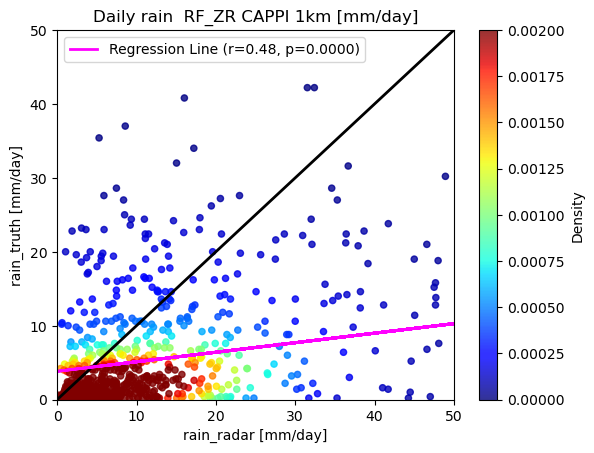

RMSE: 30.494344455269818
MSE: 929.9050437566451
MAE: 12.60007133617315
R-squared: 0.07355342440673818
Correlation coefficient (r): 0.4749085993236888
P-value: 3.2231154780757353e-55


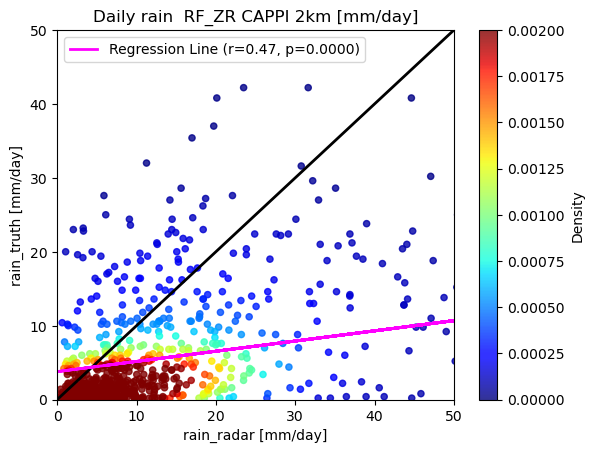

RMSE: 28.415816954450914
MSE: 807.45865318886
MAE: 11.932803794855156
R-squared: 0.09610949077742947
Correlation coefficient (r): 0.5072865240929926
P-value: 5.601416059064052e-64


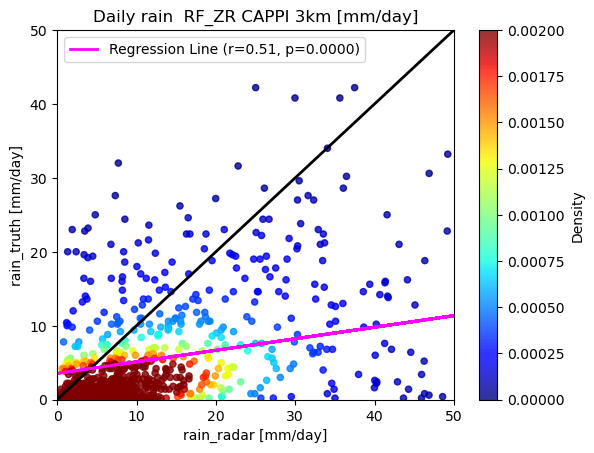

RMSE: 30.279566508431916
MSE: 916.8521479385518
MAE: 11.663084579537284
R-squared: 0.06187368193106557
Correlation coefficient (r): 0.4210548022874809
P-value: 1.3997738350582854e-42


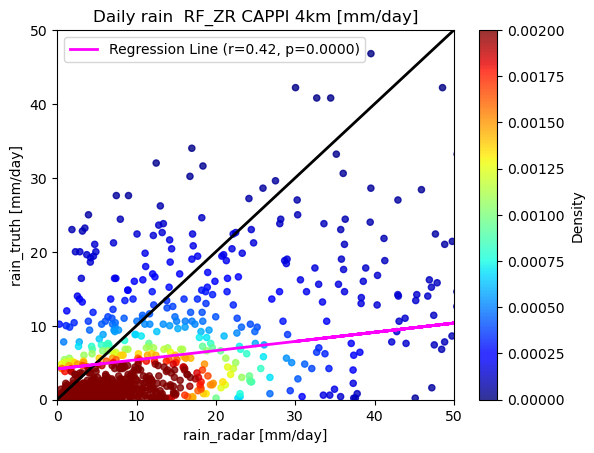

,0,1,2,3,4,5
0,2.913329,33.133793,1097.848251,13.759997,0.069777,0.481666
1,2.775422,30.494344,929.905044,12.600071,0.073553,0.474909
2,2.699656,28.415817,807.458653,11.932804,0.096109,0.507287
3,2.607829,30.279567,916.852148,11.663085,0.061874,0.421055


In [16]:
stat_rf=[]
bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_RF_c1'],' RF_ZR CAPPI 1km ')
stat_rf.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_RF_c2'],' RF_ZR CAPPI 2km ')
stat_rf.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_RF_c3'],' RF_ZR CAPPI 3km ')
stat_rf.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_RF_c4'],' RF_ZR CAPPI 4km ')
stat_rf.append((bias,rmse,mse,mae,r2,r_value))

stat_rf_df=pd.DataFrame(stat_rf)
stat_rf_df

RMSE: 14.405245220385764
MSE: 207.5110898594469
MAE: 7.574448452223976
R-squared: 0.18244608197886314
Correlation coefficient (r): 0.5236789146718523
P-value: 8.730415426160195e-69


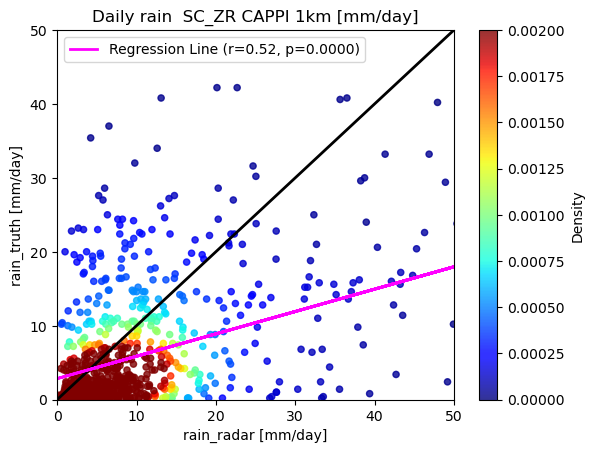

RMSE: 13.3378798707139
MSE: 177.89903944559506
MAE: 7.030617348051408
R-squared: 0.17751898201742344
Correlation coefficient (r): 0.527727598962599
P-value: 5.160611960806133e-70


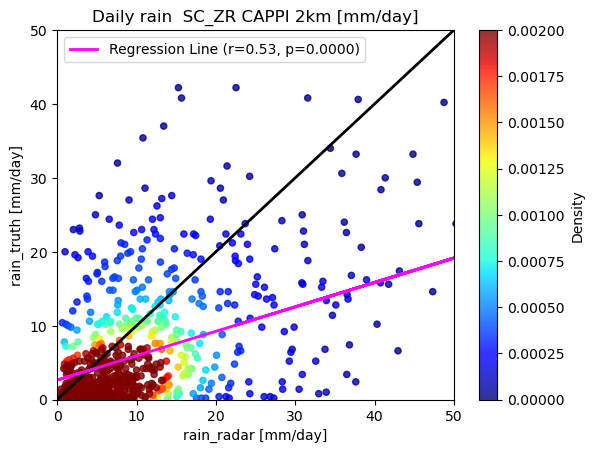

RMSE: 12.479518888859191
MSE: 155.73839169739335
MAE: 6.775962195846404
R-squared: 0.20923407069627764
Correlation coefficient (r): 0.5603949745276254
P-value: 1.465362383338325e-80


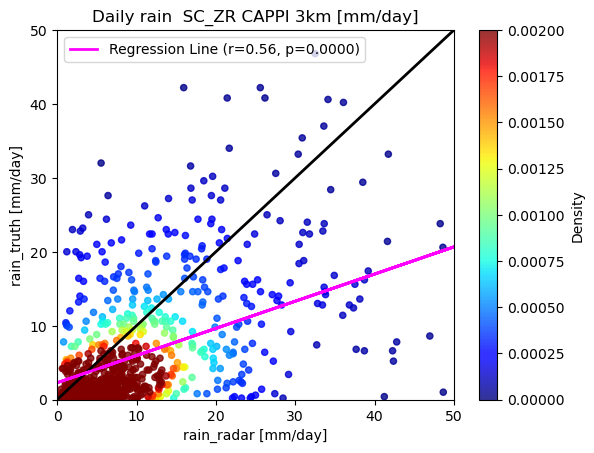

RMSE: 13.42901897713444
MSE: 180.33855068823692
MAE: 6.970566979595529
R-squared: 0.12994468574924378
Correlation coefficient (r): 0.48522469473806124
P-value: 6.584915919509584e-58


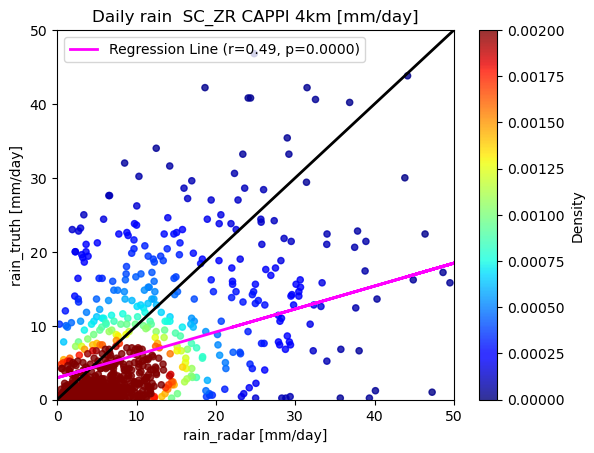

,0,1,2,3,4,5
0,1.774863,14.405245,207.511090,7.574448,0.182446,0.523679
1,1.725207,13.337880,177.899039,7.030617,0.177519,0.527728
2,1.708268,12.479519,155.738392,6.775962,0.209234,0.560395
3,1.671595,13.429019,180.338551,6.970567,0.129945,0.485225


In [17]:
stat_sc=[]
bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_SC_c1'],' SC_ZR CAPPI 1km ')
stat_sc.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_SC_c2'],' SC_ZR CAPPI 2km ')
stat_sc.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_SC_c3'],' SC_ZR CAPPI 3km ')
stat_sc.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_SC_c4'],' SC_ZR CAPPI 4km ')
stat_sc.append((bias,rmse,mse,mae,r2,r_value))

stat_sc_df=pd.DataFrame(stat_sc)
stat_sc_df

In [18]:
stat_sc_df

,0,1,2,3,4,5
0,1.774863,14.405245,207.511090,7.574448,0.182446,0.523679
1,1.725207,13.337880,177.899039,7.030617,0.177519,0.527728
2,1.708268,12.479519,155.738392,6.775962,0.209234,0.560395
3,1.671595,13.429019,180.338551,6.970567,0.129945,0.485225


#### สถิติฝนสองแหล่ง

In [19]:
### สถิติฝนสองแหล่ง
# bias,rmse,mse,mae,r2,r_value
print(stat_mp_df)
print(stat_rf_df)
print(stat_sc_df)

          0          1           2         3         4         5
0  1.857434  12.490166  156.004248  7.701075  0.128946  0.549744
1  1.828486  11.706210  137.035356  7.333256  0.114095  0.559747
2  1.828984  11.174054  124.859476  7.250216  0.136815  0.588649
3  1.805655  11.881825  141.177777  7.451584  0.057532  0.522502
          0          1            2          3         4         5
0  2.913329  33.133793  1097.848251  13.759997  0.069777  0.481666
1  2.775422  30.494344   929.905044  12.600071  0.073553  0.474909
2  2.699656  28.415817   807.458653  11.932804  0.096109  0.507287
3  2.607829  30.279567   916.852148  11.663085  0.061874  0.421055
          0          1           2         3         4         5
0  1.774863  14.405245  207.511090  7.574448  0.182446  0.523679
1  1.725207  13.337880  177.899039  7.030617  0.177519  0.527728
2  1.708268  12.479519  155.738392  6.775962  0.209234  0.560395
3  1.671595  13.429019  180.338551  6.970567  0.129945  0.485225


In [20]:
stat_mp_df['cappi']=[1,2,3,4]
stat_rf_df['cappi']=[1,2,3,4]
stat_sc_df['cappi']=[1,2,3,4]

In [21]:
stat_mp_df['ZR relationship']='MS/PM'
stat_rf_df['ZR relationship']='RF'
stat_sc_df['ZR relationship']='SC'
print(stat_mp_df)
print(stat_rf_df)
print(stat_sc_df)

          0          1           2         3         4         5  cappi  \
0  1.857434  12.490166  156.004248  7.701075  0.128946  0.549744      1   
1  1.828486  11.706210  137.035356  7.333256  0.114095  0.559747      2   
2  1.828984  11.174054  124.859476  7.250216  0.136815  0.588649      3   
3  1.805655  11.881825  141.177777  7.451584  0.057532  0.522502      4   

  ZR relationship  
0           MS/PM  
1           MS/PM  
2           MS/PM  
3           MS/PM  
          0          1            2          3         4         5  cappi  \
0  2.913329  33.133793  1097.848251  13.759997  0.069777  0.481666      1   
1  2.775422  30.494344   929.905044  12.600071  0.073553  0.474909      2   
2  2.699656  28.415817   807.458653  11.932804  0.096109  0.507287      3   
3  2.607829  30.279567   916.852148  11.663085  0.061874  0.421055      4   

  ZR relationship  
0              RF  
1              RF  
2              RF  
3              RF  
          0          1           2    

In [22]:
#### รวม dataframe by concat
frames = [stat_mp_df,stat_rf_df,stat_sc_df]
df_zr= pd.concat(frames)
#print(df_zr)

#### rename columns # bias,rmse,mse,mae,r2,r_value
df_zr.rename(columns={0: "bias", 1: "rmse",2:"mse",3:"mae", 4:"r2", 5:"r"}, inplace=True)


In [23]:
df_zr.columns

Index(['bias', 'rmse', 'mse', 'mae', 'r2', 'r', 'cappi', 'ZR relationship'], dtype='object')

In [24]:
df_zr

,bias,rmse,mse,mae,r2,r,cappi,ZR relationship
0,1.857434,12.490166,156.004248,7.701075,0.128946,0.549744,1,MS/PM
1,1.828486,11.706210,137.035356,7.333256,0.114095,0.559747,2,MS/PM
2,1.828984,11.174054,124.859476,7.250216,0.136815,0.588649,3,MS/PM
3,1.805655,11.881825,141.177777,7.451584,0.057532,0.522502,4,MS/PM
0,2.913329,33.133793,1097.848251,13.759997,0.069777,0.481666,1,RF
1,2.775422,30.494344,929.905044,12.600071,0.073553,0.474909,2,RF
2,2.699656,28.415817,807.458653,11.932804,0.096109,0.507287,3,RF
3,2.607829,30.279567,916.852148,11.663085,0.061874,0.421055,4,RF
0,1.774863,14.405245,207.511090,7.574448,0.182446,0.523679,1,SC
1,1.725207,13.337880,177.899039,7.030617,0.177519,0.527728,2,SC


## พลอตกราฟ สถิติ
bias,rmse,mse,mae,r2,r_value

#### Mean Field Bias

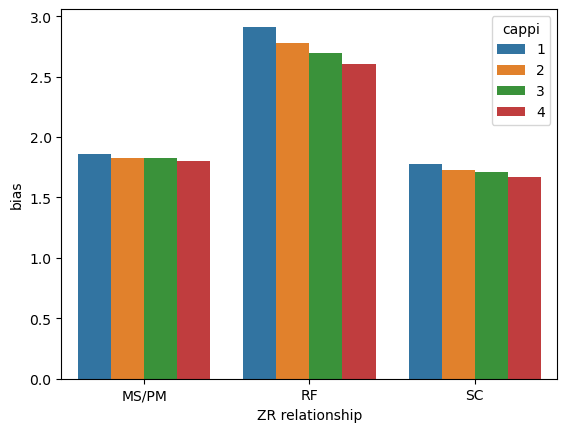

In [25]:
sns.barplot(x = 'ZR relationship', y = 'bias', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

#### r_value

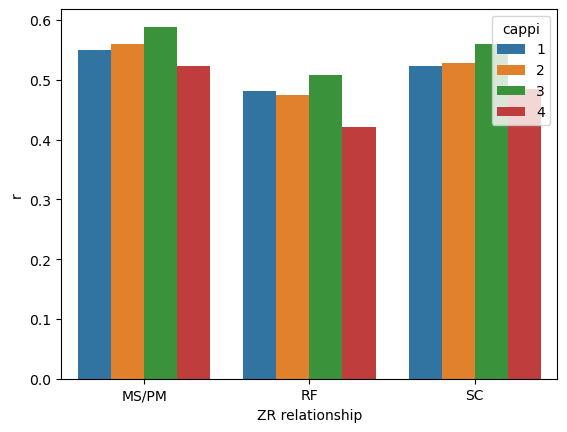

In [26]:
sns.barplot(x = 'ZR relationship', y = 'r', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

#### rmse

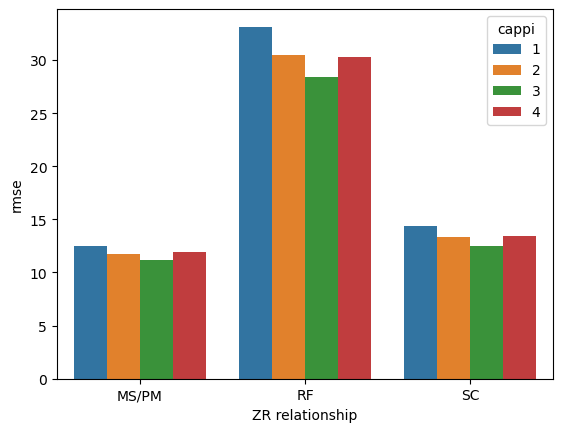

In [27]:
sns.barplot(x = 'ZR relationship', y = 'rmse', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

#### mae

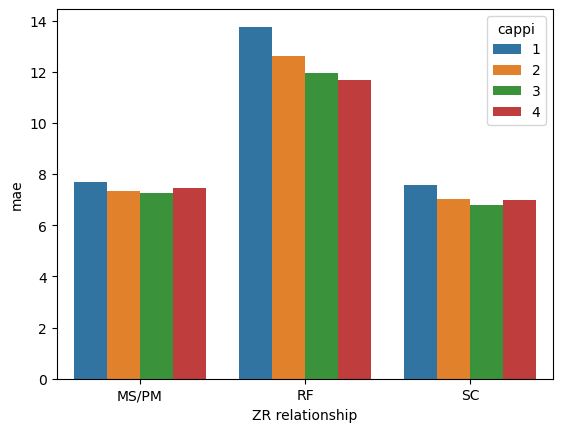

In [28]:
sns.barplot(x = 'ZR relationship', y = 'mae', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

#### r2

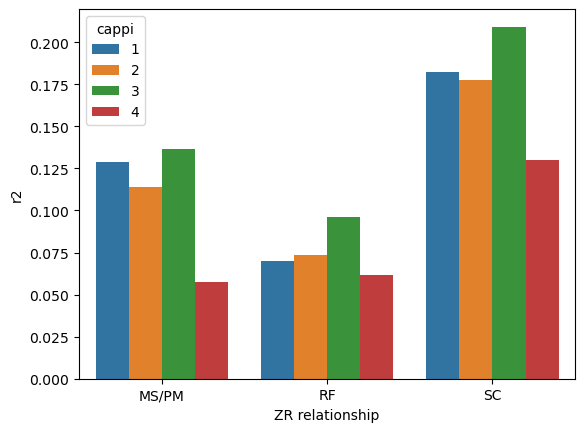

In [29]:
sns.barplot(x = 'ZR relationship', y = 'r2', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

## ข้อสังเกต
* bias MS/PM ค่อนข้างต่ำ ค่า corr ก็ค่อนข้างดีกว่า zr ตัวอื่น 
* ควรทดสอบการปรับแก้ MFB 

## ทดสอบปรับแก้ MFB

In [30]:
df_=aggregated_data
MFB=df_['rr_MP_c1'].mean()/df_['rain_truth'].mean()

# ทดสอบปรับแก้ MFB ด้วยการคูณเข้ากับฝนประมาณค่าจากเรดาร์
df_['corrected_rr_MP_c1']=df_['rr_MP_c1']*(1/MFB)    

#ต้องนำ MFB ไปปรับแก้ค่าฝน validate / testing

In [31]:
def density_plot_joint_events(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=10, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')

    # Set x and y axis limits
    max_=50
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm]')
    plt.ylabel('rain_truth [mm]')
    plt.title('Events rain_radar and rain_truth [mm]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

RMSE: 10.83816400346399
MSE: 117.46579896598259
MAE: 5.972190520438471
R-squared: 0.10901071008456265
Correlation coefficient (r): 0.5374791718262393
P-value: 3.757139834562683e-147


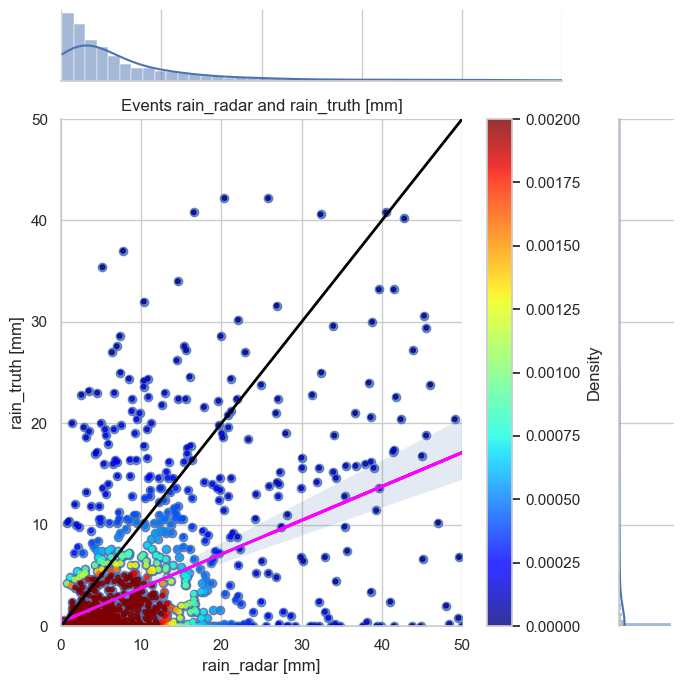

In [32]:
# ก่อนปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c1'])

RMSE: 6.047734257665553
MSE: 36.57508965134152
MAE: 3.038131677678803
R-squared: -0.8584744576754797
Correlation coefficient (r): 0.5374791718262395
P-value: 3.7571398345611855e-147


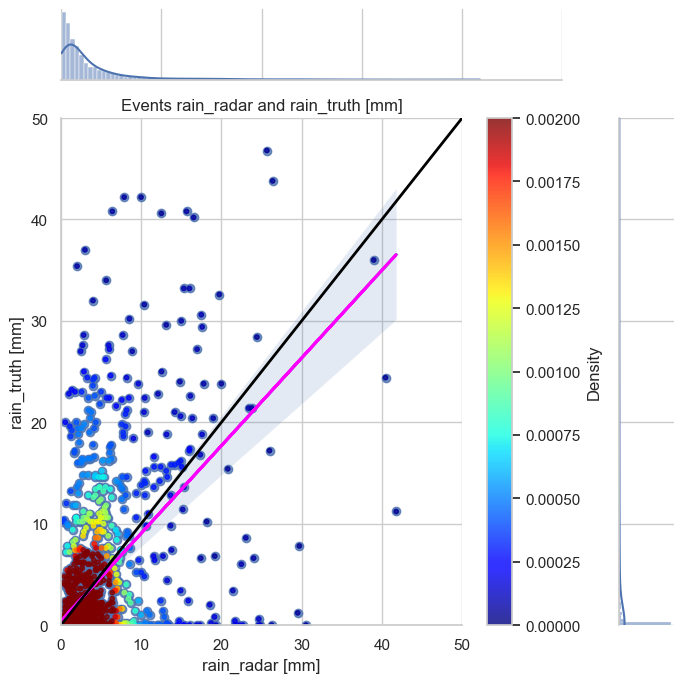

In [33]:
# หลังปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['corrected_rr_MP_c1'])

RMSE: 10.108516988657433
MSE: 102.18211570997593
MAE: 5.723763036615475
R-squared: 0.10607297421852901
Correlation coefficient (r): 0.5529559872836607
P-value: 2.2413939367610537e-157


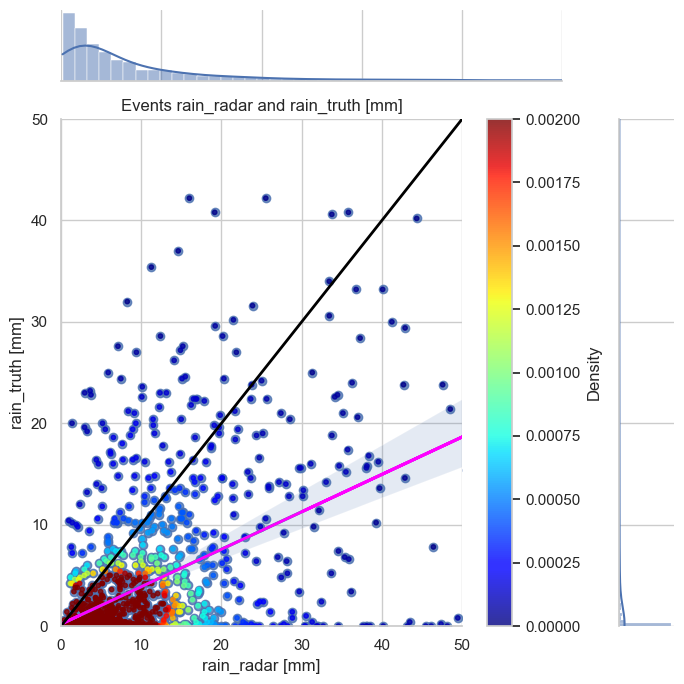

In [34]:
# ก่อนปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c2'])

In [36]:
df_=aggregated_data
MFB=df_['rr_MP_c2'].mean()/df_['rain_truth'].mean()

# ทดสอบปรับแก้ MFB ด้วยการคูณเข้ากับฝนประมาณค่าจากเรดาร์
df_['corrected_rr_MP_c2']=df_['rr_MP_c2']*(1/MFB)    

#ต้องนำ MFB ไปปรับแก้ค่าฝน validate / testing

RMSE: 5.952066693880551
MSE: 35.42709792840215
MAE: 3.0035969453735634
R-squared: -0.994255518007666
Correlation coefficient (r): 0.5529559872836607
P-value: 2.2413939367610537e-157


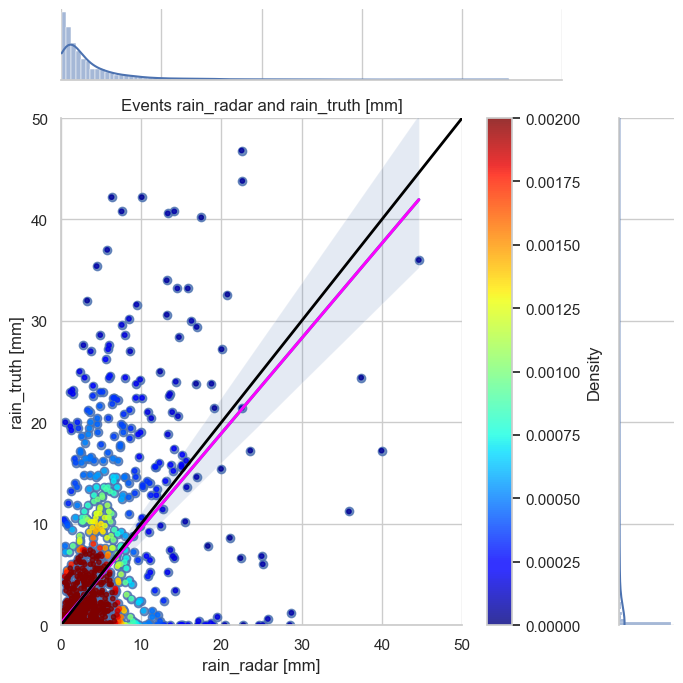

In [37]:
# หลังปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['corrected_rr_MP_c2'])

RMSE: 10.9822847432165
MSE: 120.61057818108591
MAE: 5.264322828286982
R-squared: 0.16533715670645655
Correlation coefficient (r): 0.532658379569523
P-value: 4.488690459698469e-144


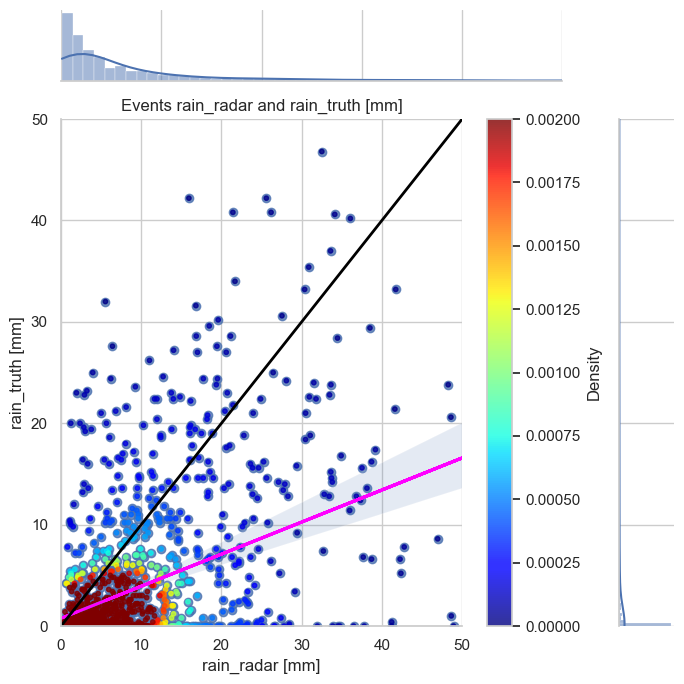

In [41]:
# ก่อนปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['rr_SC_c3'])

In [42]:
df_=aggregated_data
MFB=df_['rr_SC_c3'].mean()/df_['rain_truth'].mean()

# ทดสอบปรับแก้ MFB ด้วยการคูณเข้ากับฝนประมาณค่าจากเรดาร์
df_['corrected_rr_SC_c3']=df_['rr_SC_c3']*(1/MFB)    

#ต้องนำ MFB ไปปรับแก้ค่าฝน validate / testing

RMSE: 6.178872873618832
MSE: 38.178469988342634
MAE: 2.941295012637493
R-squared: -0.46463536547991224
Correlation coefficient (r): 0.5326583795695236
P-value: 4.4886904596943794e-144


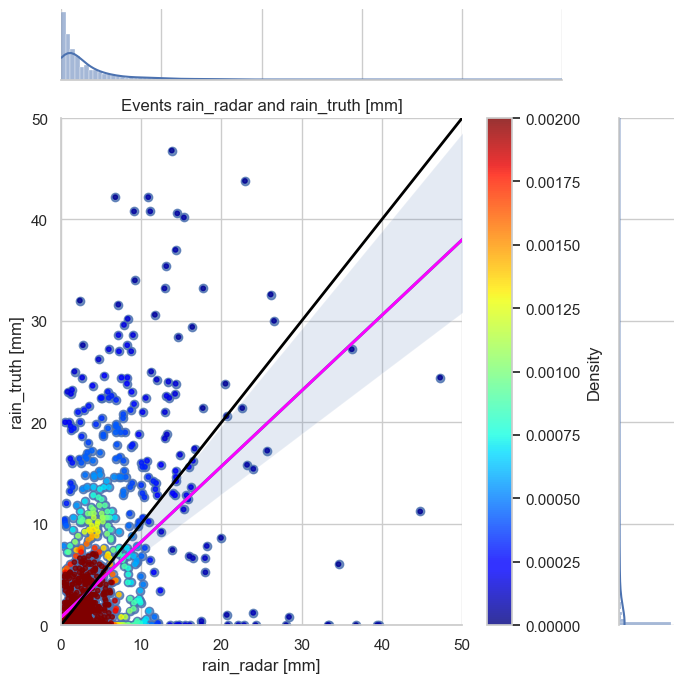

In [43]:
# หลังปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['corrected_rr_SC_c3'])

# สิ่งที่พบ
* สถิติที่วัดได้ออกมา พบว่าการใช้ mean dBZ มาทำฝนรายชั่วโมงให้ค่า สถิติที่ดีกว่าในการประมารค่าฝนรายวันทั้งก่อนและหลังปรับแก้
* ต้องนำไปทำเป็นตารางเปรียบเทียบ แสดงในเปเปอร์

# next
* ทดสอบ ML ที่ remove หรือ ปรับแก้ bias ในแต่ละมุมยกได้ดี หรือ สร้างแบบจำลองได้ดี  โดยต้องส่งออกฝนรายวันออกไปก่อนจากไฟล์นี้